In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy


### class definitions
class WeightMatrix:
    def __init__(self, g, Ej_list, Bij_list, Fij_list):
        self.g = g
        self.graph_edges = list(g.edges())
        self.n_nodes = len(list(g.nodes()))
        self.n_edges = len(list(g.edges()))
        self.edge_array = self._get_edge_array()
        self.Ej_list = np.array(Ej_list, dtype = np.float64)
        self.Bij_list = np.array(Bij_list, dtype = np.float64)
        self.Fij_list = np.array(Fij_list, dtype = np.float64)
        self.W_mat = self._create_W_mat(Ej_list, Bij_list, Fij_list)
        self.zero_array = jnp.zeros(len(list(g.nodes())) + 1).at[-1].set(1)
        self.dWijdE_list = [np.array(self.edge_array[:,1] == k, dtype=int) for k in range(self.n_nodes)]
        self.dWjidE_list = [np.array(self.edge_array[:,0] == k, dtype=int) for k in range(self.n_nodes)]
        
    
    def _create_W_mat(self, Ej_list, Bij_list, Fij_list):
        """
        Create the weight matrix of a network based on given parameters and edge structure.
        
        Parameters:
        - graph_edges: List of edge pairs [(source, target), ...]
        - Ej_list: Array of node parameters
        - Bij_list: Array of edge bias parameters
        - Fij_list: Array of edge flow parameters
        
        Returns:
        - numpy array containing the weight matrix
        """
        n_nodes = len(Ej_list)
        i_inds, j_inds = self.edge_array[:, 0], self.edge_array[:, 1]  # Extract node indices

        # Compute weights
        Wij_list = np.exp(-Bij_list + Ej_list[j_inds] + Fij_list / 2)
        Wji_list = np.exp(-Bij_list + Ej_list[i_inds] - Fij_list / 2)

        # Initialize and populate the weight matrix
        W_mat = np.zeros((n_nodes, n_nodes))
        W_mat[i_inds, j_inds] = Wij_list
        W_mat[j_inds, i_inds] = Wji_list

        # Adjust diagonal elements
        W_mat[np.arange(n_nodes), np.arange(n_nodes)] = -np.sum(W_mat, axis=0)

        return W_mat
    

    def _get_edge_array(self):
        edge_index_list = []
        for i, (src, tgt) in enumerate(self.graph_edges):
            edge_index_list.append([src, tgt])
        return np.array(edge_index_list)
    

    # def create_weight_matrix(graph_edges, Ej_list, Bij_list, Fij_list):
    #     """
    #     Update the weight matrix of a network based on given parameters and edge structure.
        
    #     Parameters:
    #     - graph_edges: List of edge pairs [(source, target), ...]
    #     - ej_list: Array of node parameters
    #     - bij_list: Array of edge bias parameters
    #     - fij_list: Array of edge flow parameters
        
    #     Returns:
    #     - numpy array containing the weight matrix
    #     """
    #     W_mat = np.zeros((self.n_nodes, self.n_nodes), dtype = np.float32)
        
    #     # Populate the weight matrix using given formulas
    #     for e, (i, j) in enumerate(graph_edges):
    #         Bij = Bij_list[e]
    #         Fij = Fij_list[e]
    #         Ei = Ej_list[i]
    #         Ej = Ej_list[j]
            
    #         # Calculate weights
    #         Wij = exp(-Bij + Ej + Fij/2)
    #         Wji = exp(-Bij + Ei - Fij/2)
            
    #         # Update matrix elements
    #         W_mat[i, j] = Wij
    #         W_mat[j, i] = Wji
        
    #     # Adjust the diagonal elements of the weight matrix
    #     for i in range(self.n_nodes):
    #         W_mat[i, i] = -np.sum(W_mat[:, i])
        
    #     return W_mat
    
    @staticmethod
    @partial(jax.jit)
    def get_steady_state(A, zero_array):
        # x, *_ = jax.scipy.sparse.linalg.bicgstab(A.T @ A, A.T @ zero_array, tol=1e-6, maxiter=5000)
        x, *_ = jax.scipy.sparse.linalg.cg(A.T @ A, A.T @ zero_array, tol=1e-10, maxiter=100000)
        # x, *_ = jax.scipy.sparse.linalg.gmres(A.T @ A, A.T @ zero_array, tol=1e-10, maxiter=100000)
        return x
        
    def current_steady_state(self):
        return self.get_steady_state(self.augmented_W_mat(), self.zero_array)
    
    def set_W_mat(self, Ej_list, Bij_list, Fij_list):
        """
        Compute and set the weight matrix based on node and edge parameters.

        Parameters:
        - Ej_list: Array of node parameters
        - Bij_list: Array of edge bias parameters
        - Fij_list: Array of edge flow parameters
        """
        i_inds, j_inds = self.edge_array[:, 0], self.edge_array[:, 1]  # Extract node indices

        # Compute weights
        Wij_list = np.exp(-Bij_list + Ej_list[j_inds] + Fij_list / 2)
        Wji_list = np.exp(-Bij_list + Ej_list[i_inds] - Fij_list / 2)

        # Reset and populate the weight matrix
        self.W_mat.fill(0.0)
        self.W_mat[i_inds, j_inds] = Wij_list
        self.W_mat[j_inds, i_inds] = Wji_list

        # Adjust diagonal elements
        self.W_mat[np.arange(self.n_nodes), np.arange(self.n_nodes)] = -np.sum(self.W_mat, axis=0)
        self.Ej_list = Ej_list
        self.Bij_list = Bij_list
        self.Fij_list = Fij_list

    def get_Wijs(self):
        Wij_list = np.array(self.W_mat[self.edge_array[:, 0], self.edge_array[:, 1]], dtype = np.float64)  # Vectorized access
        Wji_list = np.array(self.W_mat[self.edge_array[:, 1], self.edge_array[:, 0]], dtype = np.float64)  # Vectorized access
        return Wij_list, Wji_list  # Already NumPy arrays
    
    def get_external_Wijs(self, W_mat):
        dWij_list = np.array(W_mat[self.edge_array[:, 0], self.edge_array[:, 1]], dtype = np.float64)  # Vectorized access
        dWji_list = np.array(W_mat[self.edge_array[:, 1], self.edge_array[:, 0]], dtype = np.float64)  # Vectorized access
        return dWij_list, dWji_list  # Already NumPy arrays

        
    def get_dWijs(weight_matrix, dW_mat):
        src, tgt = weight_matrix.edge_array[:, 0], weight_matrix.edge_array[:, 1]
        dWij_list = dW_mat[:, src, tgt] - dW_mat[:, tgt, tgt]  # Vectorized access
        dWji_list = dW_mat[:, tgt, src] - dW_mat[:, src, src]  # Vectorized access
        return dWij_list, dWji_list  # Already NumPy arrays

    def apply_inputs(self, input_inds, inputs):
        W_mat_ret = self.W_mat.copy()
        for m, input_ind in enumerate(input_inds):
            for sub_input_ind in input_ind:
                (i, j) = self.graph_edges[sub_input_ind]
                W_mat_ret[i, j] *= np.exp(inputs[m] / 2)
                W_mat_ret[j, i] *= np.exp(-inputs[m] / 2)
        
        for i in range(self.n_nodes):
            W_mat_ret[i, i] = 0.0
            W_mat_ret[i, i] = -np.sum(W_mat_ret[:, i])
        
        return W_mat_ret
    
    # def derivatives_of_ss(self, input_inds, inputs, output_inds = []):

    #     A = self.augmented_input_W_mat(input_inds, inputs)
    #     jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, self.zero_array))

    #     dW_mat = jacobian_fn(A)
    #     Wijs, Wjis = self.get_external_Wijs(A)

    #     if len(output_inds) > 0:
    #         num_outs = len(output_inds)
    #         dEj_lists = np.zeros((num_outs, self.n_nodes))
    #         dBij_lists = np.zeros((num_outs, self.n_edges))
    #         dFij_lists = np.zeros((num_outs, self.n_edges))
    #         for (i, output_ind) in enumerate(output_inds): 
    #             dWijs, dWjis = self.get_dWijs(dW_mat[output_ind])
    #             dEj_list = [np.dot(dWijs * Wijs, self.dWijdE_list[k]) +  np.dot(dWjis * Wjis, self.dWjidE_list[k]) for k in range(self.n_nodes)]
    #             dBij_list = - (dWijs * Wijs + dWjis * Wjis)
    #             dFij_list = 0.5 * (dWijs * Wijs - dWjis * Wjis)

    #             dEj_lists[i, :] = dEj_list
    #             dBij_lists[i, :] = dBij_list
    #             dFij_lists[i, :] = dFij_list
                
    #     else:
    #         dEj_lists = np.zeros((self.n_nodes, self.n_nodes))
    #         dBij_lists = np.zeros((self.n_nodes, self.n_edges))
    #         dFij_lists = np.zeros((self.n_nodes, self.n_edges))
    #         for n in range(self.n_nodes): 
    #             dWijs, dWjis = self.get_dWijs(dW_mat[n])
    #             dEj_list = [np.dot(dWijs * Wijs, self.dWijdE_list[k]) +  np.dot(dWjis * Wjis, self.dWjidE_list[k]) for k in range(self.n_nodes)]
    #             dBij_list = - (dWijs * Wijs + dWjis * Wjis)
    #             dFij_list = 0.5 * (dWijs * Wijs - dWjis * Wjis)

    #             dEj_lists[n, :] = dEj_list
    #             dBij_lists[n, :] = dBij_list
    #             dFij_lists[n, :] = dFij_list

    #     return dEj_lists, dBij_lists, dFij_lists
    
    # def derivatives_of_ss(self, input_inds, inputs):

    #     A = self.augmented_input_W_mat(input_inds, inputs)
    #     jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, self.zero_array))

    #     dW_mat = jacobian_fn(A)
    #     Wijs, Wjis = self.get_external_Wijs(A)

    #     dEj_lists = np.zeros((self.n_nodes, self.n_nodes))
    #     dBij_lists = np.zeros((self.n_nodes, self.n_edges))
    #     dFij_lists = np.zeros((self.n_nodes, self.n_edges))

    #     dWij_list = []
    #     for n in range(self.n_nodes): 
    #         dWijs, dWjis = self.get_dWijs(dW_mat[n])
    #         dEj_list = [np.dot(dWijs * Wijs, self.dWijdE_list[k]) +  np.dot(dWjis * Wjis, self.dWjidE_list[k]) for k in range(self.n_nodes)]
    #         dBij_list = - (dWijs * Wijs + dWjis * Wjis)
    #         dFij_list = 0.5 * (dWijs * Wijs - dWjis * Wjis)

    #         dEj_lists[n, :] = dEj_list
    #         dBij_lists[n, :] = dBij_list
    #         dFij_lists[n, :] = dFij_list

    #     return dEj_lists, dBij_lists, dFij_lists
    
    def derivatives_of_ss(self, input_inds, inputs):

        A = self.augmented_input_W_mat(input_inds, inputs)
        jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, self.zero_array))

        dW_mat = jacobian_fn(A)

        Wijs, Wjis = self.get_external_Wijs(A)
        dWijs_full, dWjis_full = self.get_dWijs(dW_mat)

        dWijs_times_Wijs = dWijs_full * Wijs # shape (n_nodes, n_edges)
        dWjis_times_Wjis = dWjis_full * Wjis # shape (n_nodes, n_edges)

        dEj_lists = np.array([np.dot(dWijs_times_Wijs, self.dWijdE_list[k]) + np.dot(dWjis_times_Wjis, self.dWjidE_list[k]) for k in range(self.n_nodes)]).T
        dBij_lists = - dWijs_times_Wijs - dWjis_times_Wjis
        dFij_lists = 0.5 * (dWijs_times_Wijs - dWjis_times_Wjis)
    
        return dEj_lists, dBij_lists, dFij_lists

    def compute_ss_on_inputs(self, input_inds, inputs):
        input_W_mat = self.apply_inputs(input_inds, inputs)
        return self.get_steady_state(self.augment_other(input_W_mat), self.zero_array)
    
    def augmented_W_mat(self):
        return jnp.vstack([self.W_mat, jnp.ones((1, self.n_nodes))])
    
    def augmented_input_W_mat(self, input_inds, inputs):
        return jnp.vstack([self.apply_inputs(input_inds, inputs), jnp.ones((1, self.n_nodes))])
    
    def augment_other(self, other_W_mat):
        return jnp.vstack([other_W_mat, jnp.ones((1, self.n_nodes))])
    
    def lower_output_energies(self, output_inds, fac):
        for output_ind in output_inds:
            self.Ej_list[output_ind] -= fac
            
        self.set_W_mat(self.Ej_list, self.Bij_list, self.Fij_list)

    def nudged_ss(self, nudge, input_inds, inputs, output_inds):
        W_mat_nudged = self.apply_inputs(input_inds, inputs)
        for i, output_ind in enumerate(output_inds):
            W_mat_nudged[:,output_ind] = W_mat_nudged[:,output_ind] * exp(-nudge[i])

        for i in range(self.n_nodes):
            W_mat_nudged[i, i] = 0.0
            W_mat_nudged[i, i] = -np.sum(W_mat_nudged[:, i])

        return self.get_steady_state(self.augment_other(W_mat_nudged), self.zero_array)
        

    def update(self, nudged_ss, ss, dEj_lists, dBij_lists, dFij_lists, eta):

        ss_frac = nudged_ss / ss
        ss_diff = ss - nudged_ss

        incrEj_list = np.zeros(self.n_nodes)
        incrBij_list = np.zeros(self.n_edges)
        incrFij_list = np.zeros(self.n_edges)

        for n in range(self.n_nodes):
            dEj_list = dEj_lists[n]
            dBij_list = dBij_lists[n]
            dFij_list = dFij_lists[n]

            incrEj_list += ss_frac[n] * dEj_list
            incrBij_list += ss_frac[n] * dBij_list
            incrFij_list += ss_frac[n] * dFij_list
        

        cu = 20
        cl = -20
        self.Ej_list = np.clip(self.Ej_list + eta * incrEj_list, cl, cu)
        # self.Ej_list = np.clip(self.Ej_list + eta * ss_diff, cl, cu)
        self.Bij_list = np.clip(self.Bij_list + eta * incrBij_list, cl, cu)
        self.Fij_list = np.clip(self.Fij_list + eta * incrFij_list, cl, cu)
        self.set_W_mat(self.Ej_list, self.Bij_list, self.Fij_list)


class InputData:
    def __init__(self, n_classes, data_list, split_fac = 0.75):
        self.n_classes = n_classes
        self.labels = self._create_labels()
        self.training_data, self.testing_data = self._split_shuffle_data(data_list, split_fac)

    def _create_labels(self):
        labels = [np.zeros(self.n_classes) for n in range(self.n_classes)]
        for n in range(self.n_classes):
            labels[n][n] = 1.0
        return labels
    
    def _split_shuffle_data(self, data_list, split_fac):
        tr_data = []
        te_data = []
        for nc in range(self.n_classes):
            sub_data = data_list[nc]
            n_train = round(np.floor(split_fac * len(sub_data)))
            random.shuffle(sub_data)

            tr_data.append(iter(sub_data[:n_train]))
            te_data.append(iter(sub_data[n_train:]))
        return tr_data, te_data


### other functions
def compute_soft_maxed_output(ss, output_inds):
    vec = [ss[x] for x in output_inds]
    max_val = np.max(vec)  # Get max value
    exp_shifted = np.exp(vec - max_val)  # Subtract max before exponentiation
    return exp_shifted / np.sum(exp_shifted)  # Normalize

def get_input_inds(n_edges, input_dim, M):
    shuffled_inds = list(range(n_edges))
    random.shuffle(shuffled_inds)
    return [shuffled_inds[m*M:(m+1)*M] for m in range(input_dim)]

def get_output_inds(n_nodes, n_classes, rand_bool):
    output_inds = list(range(n_nodes))
    if rand_bool:
        random.shuffle(output_inds)
    return output_inds[:n_classes]

def random_initial_parameters(e_range, b_range, f_range, n_nodes, n_edges):
    """
    Generate random initial parameters for a network with given ranges and dimensions.
    Returns tuple of (ej_list, bij_list, fij_list) containing random values within specified ranges.
    """
    ej_list = (2 * np.random.random(n_nodes) - 1) * e_range
    bij_list = (2 * np.random.random(n_edges) - 1) * b_range
    fij_list = (2 * np.random.random(n_edges) - 1) * f_range
    
    return (ej_list, bij_list, fij_list)

def softplus_inverse(x):
    return jnp.log(jnp.exp(x) - 1)

def softplus(x):
    return jnp.log(jnp.exp(x) + 1)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def dsoftplus_inverse(x):
    return 1 / (1 - jnp.expm1(-x))

        

In [236]:
### run training - cost function

n_training_iters = 500
eta = 1

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])

    # Compute steady state and extract output values efficiently
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    ss_at_outputs = ss[jnp.array(output_inds)]  # Vectorized indexing

    # Compute error
    true_output = input_data.labels[class_number]
    error = ss_at_outputs - true_output
    error = ss_at_outputs / true_output
    error_list.append(jnp.linalg.norm(error))  # Use JAX for compatibility

    # Compute Jacobian of steady-state output wrt parameters
    dEj_lists, dBij_lists, dFij_lists = weight_matrix.derivatives_of_ss(input_inds, inputs)

    # Compute weight updates using chain rule
    incrEj_list = jnp.einsum('n,nj->j', error, dEj_lists)
    incrBij_list = jnp.einsum('n,nj->j', error, dBij_lists)
    incrFij_list = jnp.einsum('n,nj->j', error, dFij_lists)


    # Update weights correctly
    weight_matrix.Ej_list -= eta * incrEj_list
    weight_matrix.Bij_list -= eta * incrBij_list
    weight_matrix.Fij_list -= eta * incrFij_list
    weight_matrix.set_W_mat(weight_matrix.Ej_list, weight_matrix.Bij_list, weight_matrix.Fij_list)
    


IndexError: Too many indices for array: 3 non-None/Ellipsis indices for dim 2.

In [ ]:
### run training - cost function

n_training_iters = 500
eta = 1

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])

    # Compute steady state and extract output values efficiently
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    ss_at_outputs = ss[jnp.array(output_inds)]  # Vectorized indexing

    # Compute error
    true_output = input_data.labels[class_number]
    error = ss_at_outputs - true_output
    error = ss_at_outputs / true_output
    error_list.append(jnp.linalg.norm(error))  # Use JAX for compatibility

    # Compute Jacobian of steady-state output wrt parameters
    dEj_lists, dBij_lists, dFij_lists = weight_matrix.derivatives_of_ss(input_inds, inputs, output_inds)

    # Compute weight updates using chain rule
    incrEj_list = jnp.einsum('n,nj->j', error, dEj_lists)
    incrBij_list = jnp.einsum('n,nj->j', error, dBij_lists)
    incrFij_list = jnp.einsum('n,nj->j', error, dFij_lists)


    # Update weights correctly
    weight_matrix.Ej_list -= eta * incrEj_list
    weight_matrix.Bij_list -= eta * incrBij_list
    weight_matrix.Fij_list -= eta * incrFij_list
    weight_matrix.set_W_mat(weight_matrix.Ej_list, weight_matrix.Bij_list, weight_matrix.Fij_list)
    


TypeError: derivatives_of_ss() takes 3 positional arguments but 4 were given

In [2]:
### initialize network input-output 
M = 1
n_classes = 2

random.seed(20)

### Initialize weight_matrix
n_nodes = 10
n_edges = 40
output_inds = get_output_inds(n_nodes, n_classes, False)

g = nx.complete_graph(n_nodes)
#g = nx.gnm_random_graph(n_nodes, n_edges)
n_edges = len(list(g.edges())) 


E_range = 0
B_range = 0
F_range = 0
# Generate random parameters
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix instance
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 2)

###  create Gaussian data
input_dim = 2  ## to-do: multidimensional generalization
n_classes = 2
n_samples = 20000

# n_samples = 20000
# mu_1 = -10
# sigma_1 = 1
# dist_1 = np.random.normal(mu_1, sigma_1, n_samples)

# mu_2 = 10
# sigma_2 = 1
# dist_2 = np.random.normal(mu_2, sigma_2, n_samples)

# data_list = [[[dat] for dat in dist_1], [[dat] for dat in dist_2]]


mu_1 = [-10, -10]
sigma_1 = 1.0 * np.array([[1, 0], [0, 1]])
dist_1 = np.random.multivariate_normal(mu_1, sigma_1, n_samples)

mu_2 = [10, 10]
sigma_2 = 1.0 * np.array([[1, 0], [0, 1]])
dist_2 = np.random.multivariate_normal(mu_2, sigma_2, n_samples)

data_list = [[dat for dat in dist_1], [dat for dat in dist_2]]


input_data = InputData(n_classes, data_list)
input_inds = get_input_inds(n_edges, input_dim, M)


print(input_inds)
# input_inds = [[9]]
# input_inds = [[20]]
print(list(weight_matrix.g.edges())[input_inds[0][0]])
#print(list(weight_matrix.g.edges())[9])

#print(list(weight_matrix.g.edges())[input_inds[1][0]])



[[8], [31]]
(0, 9)


In [ ]:



start_time = time.time()
dWij_dWji_list = np.array([weight_matrix.get_dWijs(dW_mat[n]) for n in range(weight_matrix.n_nodes)]).swapaxes(0,1) # shape (2, n_nodes, n_edges)
end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")

start_time = time.time()
dWij_list, dWji_list = get_dWijs_ext(weight_matrix, dW_mat)
end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")


Execution Time: 0.098083 seconds
Execution Time: 0.006713 seconds


In [186]:
print(np.shape(dWij_dWji_list[0]))
print(dWij_dWji_list[0,1,4])

(10, 45)
-0.0057915105


In [187]:
print(np.shape(dWij_list))
print(dWij_list[1,4])

(10, 45)
-0.005791510455310345


In [231]:
import time


A = weight_matrix.augmented_input_W_mat(input_inds, inputs)
jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))

dW_mat = jacobian_fn(A)


start_time = time.time()
Wijs, Wjis = weight_matrix.get_external_Wijs(A)

dEj_lists = np.zeros((weight_matrix.n_nodes, weight_matrix.n_nodes))
dBij_lists = np.zeros((weight_matrix.n_nodes, weight_matrix.n_edges))
dFij_lists = np.zeros((weight_matrix.n_nodes, weight_matrix.n_edges))

dWijs_full, dWjis_full = weight_matrix.get_dWijs(dW_mat)


for n in range(weight_matrix.n_nodes): 
    dWijs = dWijs_full[n]
    dWjis = dWjis_full[n]
    dEj_list = [np.dot(dWijs * Wijs, weight_matrix.dWijdE_list[k]) +  np.dot(dWjis * Wjis, weight_matrix.dWjidE_list[k]) for k in range(weight_matrix.n_nodes)]
    dBij_list = - (dWijs * Wijs + dWjis * Wjis)
    dFij_list = 0.5 * (dWijs * Wijs - dWjis * Wjis)

    dEj_lists[n, :] = dEj_list
    dBij_lists[n, :] = dBij_list
    dFij_lists[n, :] = dFij_list

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")

Execution Time: 0.034049 seconds


In [ ]:

import time


start_time = time.time()

A = weight_matrix.augmented_input_W_mat(input_inds, inputs)
jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))

dW_mat = jacobian_fn(A)

Wijs, Wjis = weight_matrix.get_external_Wijs(A)
dWijs_full, dWjis_full = weight_matrix.get_dWijs(dW_mat)



dWijs_times_Wijs = dWijs_full * Wijs # shape (n_nodes, n_edges)
dWjis_times_Wjis = dWjis_full * Wjis # shape (n_nodes, n_edges)


dEj_lists_vec = np.array([np.dot(dWijs_times_Wijs, weight_matrix.dWijdE_list[k]) + np.dot(dWjis_times_Wjis, weight_matrix.dWjidE_list[k]) for k in range(weight_matrix.n_nodes)]).T
dBij_lists_vec = - dWijs_times_Wijs - dWjis_times_Wjis
dFij_lists_vec = 0.5 * (dWijs_times_Wijs - dWjis_times_Wjis)

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.6f} seconds")




Execution Time: 0.011998 seconds


In [215]:
print(dEj_lists_vec[1,3])
print(dEj_lists[1,3])

print(dBij_lists_vec[1,5])
print(dBij_lists[1,5])

print(dFij_lists_vec[4,2])
print(dFij_lists[4,2])


0.008980878454167396
0.008980878454167396
-0.010671566
-0.010671566240489483
-0.0021984403
-0.0021984402555972338


In [3]:
### run training - clamping 

n_training_iters = 500
eta = 1
delta_E = 1

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    inputs = next(input_data.training_data[class_number])

    ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
    
    ss_at_outputs = [ss[output_ind] for output_ind in output_inds]
    true_output = input_data.labels[class_number]
    error = np.array(ss_at_outputs - true_output)
    error_list.append(np.linalg.norm(error))

    nudge = delta_E * (2 * input_data.labels[class_number] - 1)
    nudged_ss = weight_matrix.nudged_ss(nudge, input_inds, inputs, output_inds)
    ss_frac = nudged_ss / ss
    
    ## at all indices
    dEj_lists, dBij_lists, dFij_lists = weight_matrix.derivatives_of_ss(input_inds, inputs)
    incrEj_list = np.einsum('n,nj->j', ss_frac, dEj_lists)
    incrBij_list = np.einsum('n,nk->k', ss_frac, dBij_lists)
    incrFij_list = np.einsum('n,nk->k', ss_frac, dFij_lists)

    ## at select indices only
    # sel_inds = np.concatenate([np.array(input_inds).flatten(), np.array(output_inds).flatten()])
    # sel_inds = output_inds
    # ss_frac_out = ss[jnp.array(sel_inds)]
    # dEj_lists, dBij_lists, dFij_lists = weight_matrix.derivatives_of_ss(input_inds, inputs, sel_inds)
    # incrEj_list = np.einsum('n,nj->j', ss_frac_out, dEj_lists)
    # incrBij_list = np.einsum('n,nk->k', ss_frac_out, dBij_lists)
    # incrFij_list = np.einsum('n,nk->k', ss_frac_out, dFij_lists)

   
    weight_matrix.Ej_list = weight_matrix.Ej_list + eta * Ej_list
    weight_matrix.Bij_list = weight_matrix.Bij_list + eta * incrBij_list
    weight_matrix.Fij_list = weight_matrix.Fij_list + eta * incrFij_list
    weight_matrix.set_W_mat(weight_matrix.Ej_list, weight_matrix.Bij_list, weight_matrix.Fij_list)



(0.0, 1.0)

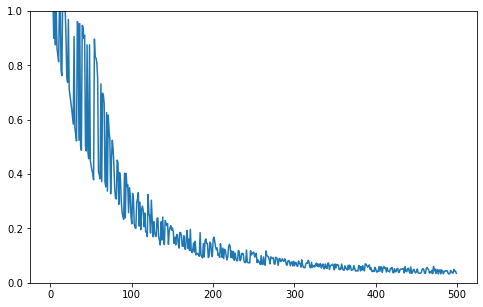

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(error_list, label="Steady State at Node 1")
plt.ylim(0,1)

In [141]:
### run training - cost function

n_training_iters = 500
eta = 1

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])

    # Compute steady state and extract output values efficiently
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    ss_at_outputs = ss[jnp.array(output_inds)]  # Vectorized indexing

    # Compute error
    true_output = input_data.labels[class_number]
    error = ss_at_outputs - true_output
    error = ss_at_outputs / true_output
    error_list.append(jnp.linalg.norm(error))  # Use JAX for compatibility

    # Compute Jacobian of steady-state output wrt parameters
    dEj_lists, dBij_lists, dFij_lists = weight_matrix.derivatives_of_ss(input_inds, inputs, output_inds)

    # Compute weight updates using chain rule
    incrEj_list = jnp.einsum('n,nj->j', error, dEj_lists)
    incrBij_list = jnp.einsum('n,nj->j', error, dBij_lists)
    incrFij_list = jnp.einsum('n,nj->j', error, dFij_lists)


    # Update weights correctly
    weight_matrix.Ej_list -= eta * incrEj_list
    weight_matrix.Bij_list -= eta * incrBij_list
    weight_matrix.Fij_list -= eta * incrFij_list
    weight_matrix.set_W_mat(weight_matrix.Ej_list, weight_matrix.Bij_list, weight_matrix.Fij_list)
    


(0.0, 1.0)

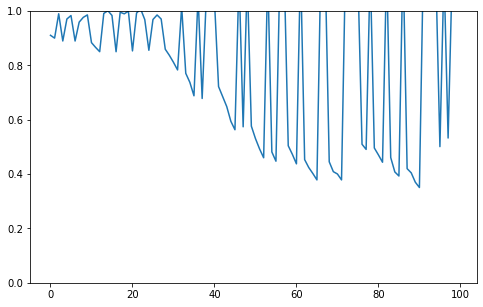

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(error_list, label="Steady State at Node 1")
plt.ylim(0,1)

In [ ]:
### run training - cost function

n_training_iters = 5000
eta = 5e-2

jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])

    # Compute steady state and extract output values efficiently
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    ss_at_outputs = ss[jnp.array(output_inds)]  # Vectorized indexing

    # Compute error
    true_output = input_data.labels[class_number]
    error = ss_at_outputs - true_output
    error_list.append(jnp.linalg.norm(error))  # Use JAX for compatibility

    # Compute Jacobian and update weights efficiently
    dW_mat = jacobian_fn(weight_matrix.augmented_input_W_mat(input_inds, input)) 

    # Vectorized weight update
    dW_mat_sub = dW_mat[jnp.array(output_inds)]  # Extract relevant rows
    dW = jnp.einsum('n,nij->ij', error, dW_mat_sub)  # Efficient summation

    # Extract dWijs and dWjis in one call
    dWijs, dWjis = weight_matrix.get_dWijs(dW)

    weight_matrix.update(dWijs, dWjis, eta)
    





(7, 9)


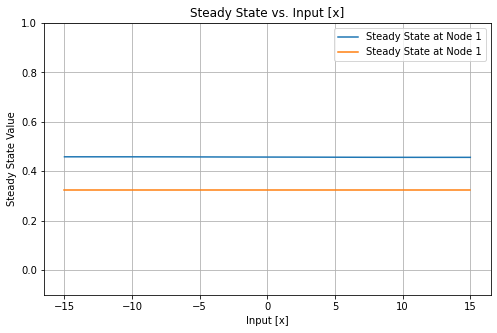

In [6]:
import matplotlib.pyplot as plt

# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = []
ss_o_values = []

print(list(weight_matrix.g.edges())[input_inds[0][0]])

out_ind = 1
# Compute steady state for each input value
for x in x_values:
    ss = weight_matrix.compute_ss_on_inputs(input_inds, [x])
    output = compute_soft_maxed_output(ss, output_inds)
    #ss_values.append(output[out_ind])
    ss_at_outputs = [ss[out] for out in output_inds]
    ss_values.append(ss_at_outputs[out_ind])  # Assuming node index 1 is of interest

    ss = weight_matrix_orig.compute_ss_on_inputs(input_inds, [x])
    output = compute_soft_maxed_output(ss, output_inds)
    #ss_o_values.append(output[out_ind])
    ss_at_outputs = [ss[out] for out in output_inds]
    ss_o_values.append(ss_at_outputs[out_ind])  # Assuming node index 1 is of interest

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values, label="Steady State at Node 1")
plt.plot(x_values, ss_o_values, label="Steady State at Node 1")
plt.xlabel("Input [x]")
plt.ylabel("Steady State Value")
plt.title("Steady State vs. Input [x]")
plt.ylim(-0.1,1.)
plt.legend()
plt.grid()
plt.show()


In [21]:
import jax
import jax.numpy as jnp

def finite_difference_jacobian(A, zero_array, epsilon=1e-4):
    """Compute the Jacobian using finite differences."""
    A = jnp.array(A)  # Ensure it's a JAX array
    n_nodes_plus_1, n_nodes = A.shape  # Assuming A is (n_nodes, n_nodes+1)
    jacobian = jnp.zeros((n_nodes, n_nodes_plus_1, n_nodes))  # Desired shape

    for i in range(n_nodes_plus_1):
        for j in range(n_nodes):
            perturb = jnp.zeros_like(A)
            perturb = perturb.at[i, j].set(epsilon)

            f_plus = WeightMatrix.get_steady_state(A + perturb, zero_array)
            f_minus = WeightMatrix.get_steady_state(A - perturb, zero_array)

            jacobian = jacobian.at[:, i, j].set((f_plus - f_minus) / (2 * epsilon))  # Exclude appended 1.0

    return jacobian


A = weight_matrix.augmented_W_mat()
zero_array = weight_matrix.zero_array

# Compute JAX Jacobian
dW_mat_jax = jacobian_fn(A)

# Compute finite difference Jacobian
dW_mat_fd = finite_difference_jacobian(A, zero_array, 1e-4)

# Compute error
error = jnp.linalg.norm(dW_mat_jax - dW_mat_fd) / jnp.linalg.norm(dW_mat_fd)
print(f"Relative error: {error:.2e}")

print(dW_mat_jax[1])
print(dW_mat_fd[1])


Relative error: 1.93e-03
[[-0.07435223 -0.02876542 -0.0028449 ]
 [ 0.10677707  0.04130996  0.00408556]
 [-0.03242485 -0.01254453 -0.00124066]
 [-0.19048452 -0.07369471 -0.00728841]]
[[-0.07450581 -0.02861023 -0.00283122]
 [ 0.10699034  0.0411272   0.00372529]
 [-0.03248453 -0.01221895 -0.0013411 ]
 [-0.19043684 -0.07361174 -0.00715256]]


In [20]:
### Initialize weight_matrix
n_nodes = 3

output_inds = get_output_inds(n_nodes, n_classes, False)

g = nx.complete_graph(n_nodes)
#g = nx.gnm_random_graph(n_nodes, n_edges)
n_edges = len(list(g.edges())) 


Ej_list = np.array(range(n_nodes))
Bij_list = np.array(range(n_edges))
Fij_list = np.array(range(n_edges))


# Create WeightMatrix instance
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 0)
print(weight_matrix.current_steady_state())
print(weight_matrix.W_mat)

[0.701684   0.27146772 0.02684817]
[[-1.22313016  2.71828183  4.48168907]
 [ 1.         -2.85361711  2.71828183]
 [ 0.22313016  0.13533528 -7.1999709 ]]


In [16]:
dWijs, dWjis = weight_matrix.get_dWijs(dW_mat[n])
dW_mat[0][0,1] - dW_mat[0][1,1]

Array(0.06924655, dtype=float32)

In [ ]:
inputs = [3]
input_inds = [[0]]


dEj_lists = np.zeros((n_nodes, n_nodes))
dBij_lists = np.zeros((n_nodes, n_edges))
dFij_lists = np.zeros((n_nodes, n_edges))

#A = weight_matrix.augmented_W_mat()
A = weight_matrix.augmented_input_W_mat(input_inds, inputs)
zero_array = weight_matrix.zero_array

jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))

# Compute JAX Jacobian

dW_mat = jacobian_fn(A)

Wijs, Wjis = weight_matrix.get_external_Wijs(A)

for n in range(n_nodes): # test these out in mathematica
    dWijs, dWjis = weight_matrix.get_dWijs(dW_mat[n])
    dEj_list = [np.dot(dWijs * Wijs, weight_matrix.dWijdE_list[k]) +  np.dot(dWjis * Wjis, weight_matrix.dWjidE_list[k]) for k in range(weight_matrix.n_nodes)]
    dBij_list = - (dWijs * Wijs + dWjis * Wjis)
    dFij_list = 0.5 * (dWijs * Wijs - dWjis * Wjis)

    dEj_lists[n, :] = dEj_list
    dBij_lists[n, :] = dBij_list
    dFij_lists[n, :] = dFij_list




def finite_difference_jacobian_inputs(weight_matrix, input_inds, inputs, epsilon=1e-3):
    """Compute the Jacobian using finite differences."""

    dEj_lists = np.zeros((n_nodes, n_nodes))
    dBij_lists = np.zeros((n_nodes, n_edges))
    dFij_lists = np.zeros((n_nodes, n_edges))
    Ej_list_c = np.array(weight_matrix.Ej_list.copy())
    Bij_list_c = np.array(weight_matrix.Bij_list.copy())
    Fij_list_c = np.array(weight_matrix.Fij_list.copy())

    for n in range(n_nodes):

        Ej_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Ej_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Ej_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dEj_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    for n in range(n_edges):

        Bij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Bij_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Bij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dBij_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    for n in range(n_edges):

        Fij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Fij_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.compute_ss_on_inputs(input_inds, inputs)
        
        Fij_list_c[n] +=  epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dFij_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    
    return dEj_lists, dBij_lists, dFij_lists

            


#print(weight_matrix.get_Wijs())
dEj_lists_fd, dBij_lists_fd, dFij_lists_fd = finite_difference_jacobian_inputs(weight_matrix, input_inds, inputs, 1e-3)
#print(weight_matrix.get_Wijs())

# n_ind = 2
# print(dEj_lists_fd[:,n_ind])
# print(dEj_lists[:,n_ind])
# print(" ")
# print(dBij_lists_fd[:,n_ind])
# print(dBij_lists[:,n_ind])
# print(" ")
# print(dFij_lists_fd[:,n_ind])
# print(dFij_lists[:,n_ind])

print(dEj_lists_fd)
print(" ")
print(dEj_lists)
print(" ")
print(dBij_lists_fd)
print(" ")
print(dBij_lists)
print(" ")
print(dFij_lists_fd)
print(" ")
print(dFij_lists)


[[-0.05069375  0.02244115  0.02816319]
 [ 0.02244767 -0.02315454  0.00070501]
 [ 0.02818461  0.00070781 -0.02888962]]
 
[[-0.05063344  0.02244807  0.02818538]
 [ 0.02244809 -0.02315434  0.00070625]
 [ 0.02818538  0.00070625 -0.02889164]]
 
[[-6.07967330e-03  1.25467768e-02 -6.46710349e-03]
 [ 6.18677540e-03 -2.07778066e-03 -4.10899520e-03]
 [-7.63684511e-05 -1.04485070e-02  1.05211502e-02]]
 
[[-6.11091089e-03  1.25262958e-02 -6.41539526e-03]
 [ 6.18404861e-03 -2.07866282e-03 -4.10537941e-03]
 [-7.31393857e-05 -1.04476254e-02  1.05207700e-02]]
 
[[ 0.01963973  0.02780556  0.00342727]
 [-0.01989398 -0.00460632  0.00222027]
 [ 0.00023656 -0.02316292 -0.00569411]]
 
[[ 0.01965751  0.02776824  0.00347259]
 [-0.01989281 -0.00460797  0.0022222 ]
 [ 0.00023528 -0.02316028 -0.00569479]]


In [ ]:
def finite_difference_jacobian(weight_matrix, epsilon=1e-3):
    """Compute the Jacobian using finite differences."""

    dEj_lists = np.zeros((n_nodes, n_nodes))
    dBij_lists = np.zeros((n_nodes, n_edges))
    dFij_lists = np.zeros((n_nodes, n_edges))
    Ej_list_c = np.array(weight_matrix.Ej_list.copy())
    Bij_list_c = np.array(weight_matrix.Bij_list.copy())
    Fij_list_c = np.array(weight_matrix.Fij_list.copy())

    for n in range(n_nodes):

        Ej_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.current_steady_state()
        
        Ej_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.current_steady_state()
        
        Ej_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dEj_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    for n in range(n_edges):

        Bij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.current_steady_state()
        
        Bij_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.current_steady_state()
        
        Bij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dBij_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    for n in range(n_edges):

        Fij_list_c[n] += epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_plus = weight_matrix.current_steady_state()
        
        Fij_list_c[n] -= 2 * epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)
        f_minus = weight_matrix.current_steady_state()
        
        Fij_list_c[n] +=  epsilon
        weight_matrix.set_W_mat(Ej_list_c, Bij_list_c, Fij_list_c)

        dFij_lists[:, n] = ((f_plus - f_minus) / (2 * epsilon))  

    
    return dEj_lists, dBij_lists, dFij_lists

(array([0.36787944, 4.48168907, 7.3890561 , 1.64872127, 2.71828183,
       1.64872127]), array([0.13533528, 0.03019738, 0.00673795, 0.00408677, 0.00091188,
       0.00408677]))
(array([0.36787944, 4.48168907, 7.3890561 , 1.64872127, 2.71828183,
       1.64872127]), array([0.13533528, 0.03019738, 0.00673795, 0.00408677, 0.00091188,
       0.00408677]))


In [13]:
weight_matrix.set_W_mat(weight_matrix.Ej_list, weight_matrix.Bij_list,weight_matrix.Fij_list)
weight_matrix.W_mat

array([[ -0.78348561,   0.14080061,   1.03316116,   1.52183807,
          4.80466175,   3.73996592],
       [  0.07300048,  -1.02263337,   0.72061312,   2.17155194,
          2.4963069 ,   6.48175621],
       [  0.07188813,   0.06291599,  -4.90187752,   0.94277555,
          4.4498868 ,   2.46617913],
       [  0.05209903,   0.31191328,   1.26930809, -10.02250046,
          1.60139477,   7.22452784],
       [  0.47199059,   0.2120707 ,   1.03136182,   2.17001581,
        -21.68503582,   3.21729183],
       [  0.11450739,   0.29493278,   0.84743333,   3.21631908,
          8.33278561, -23.12972093]])